In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import pandas as pd
import numpy as np

import random

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [3]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
#             nn.Linear(4, 16),
#             nn.ReLU(),
#             nn.Linear(16, 64),
#             nn.ReLU(),
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        result = self.classifier(encoded)
        return result

In [4]:
EPOCH = 20
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

trainset = datasets.MNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

testset = datasets.MNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

Using Device: cuda


In [5]:
autoencoder = Autoencoder().to(DEVICE)
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=0.0000001)
ae_criterion = nn.MSELoss()
loss_history= []
val_loss_history = []
loss_last_history=[]
view_data = trainset.data[10:20].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255

In [6]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        
#         mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
#         x  = (x-mean)/std
        
        encoded, decoded = autoencoder(x)
        
        loss = ae_criterion(decoded, y)
        if step == 1:
            loss_history.append(loss.data)
        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

1 / 20
[Epoch 1]


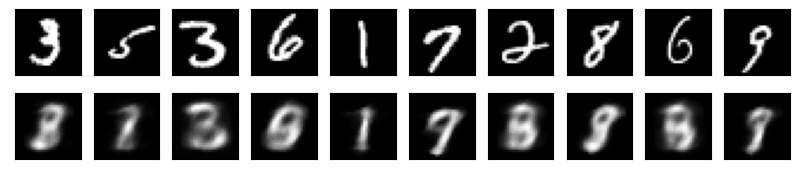

2 / 20
[Epoch 2]


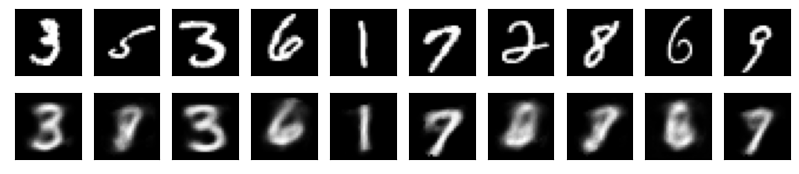

3 / 20
[Epoch 3]


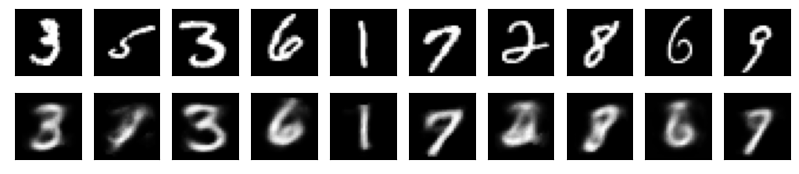

4 / 20
[Epoch 4]


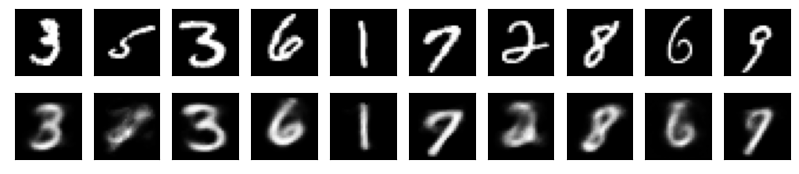

5 / 20
[Epoch 5]


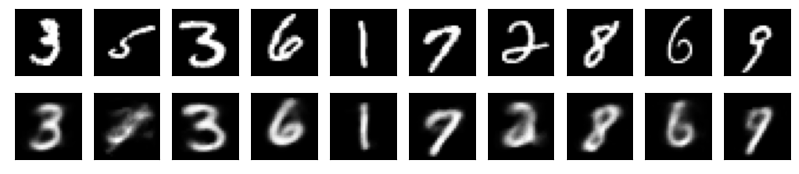

6 / 20
[Epoch 6]


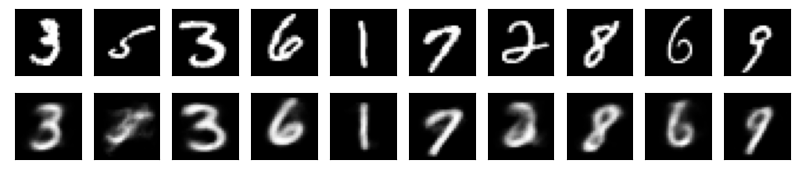

7 / 20
[Epoch 7]


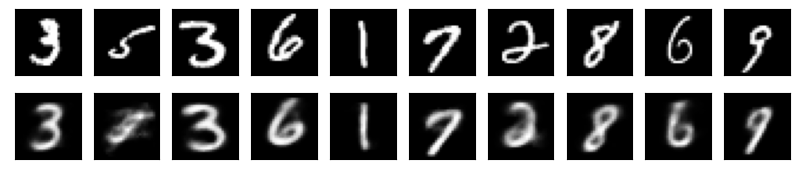

8 / 20
[Epoch 8]


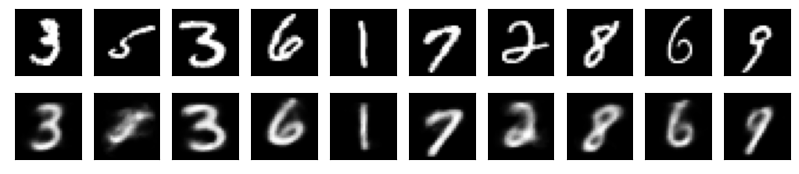

9 / 20
[Epoch 9]


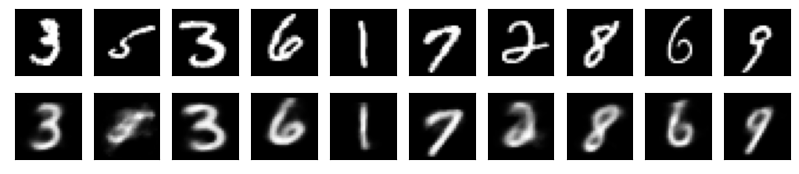

10 / 20
[Epoch 10]


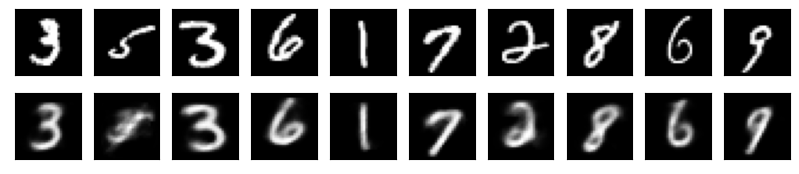

11 / 20
[Epoch 11]


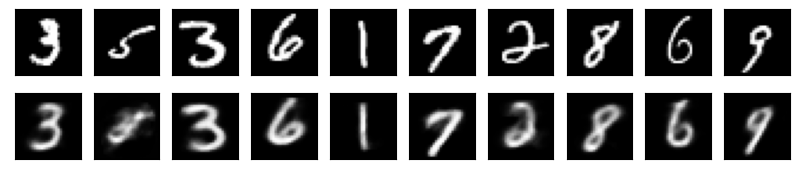

12 / 20
[Epoch 12]


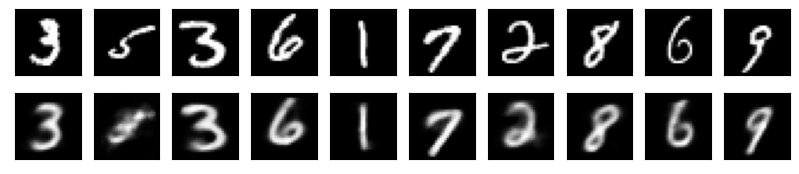

13 / 20
[Epoch 13]


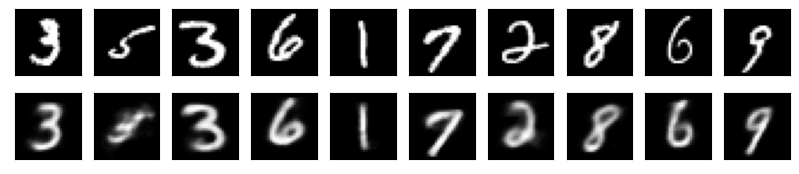

14 / 20
[Epoch 14]


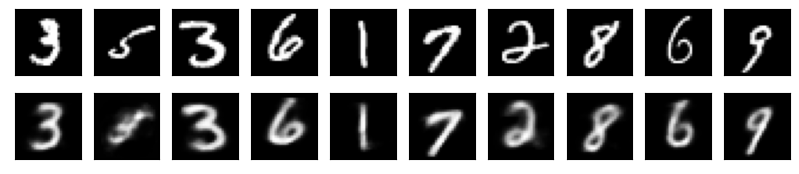

15 / 20
[Epoch 15]


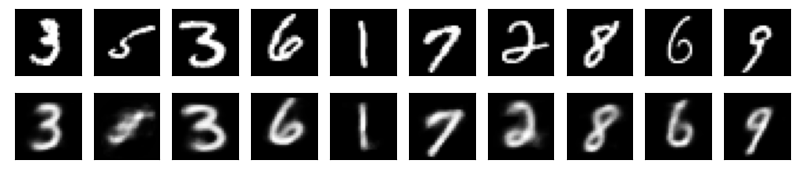

16 / 20
[Epoch 16]


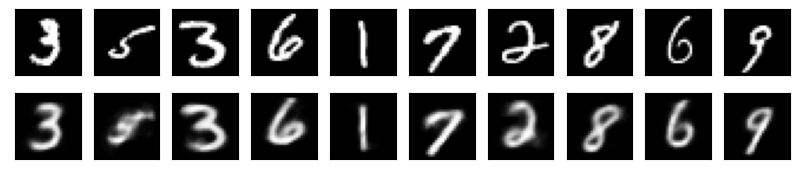

17 / 20
[Epoch 17]


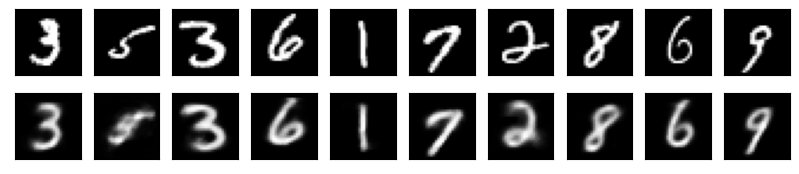

18 / 20
[Epoch 18]


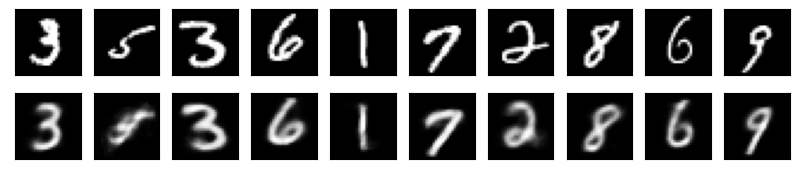

19 / 20
[Epoch 19]


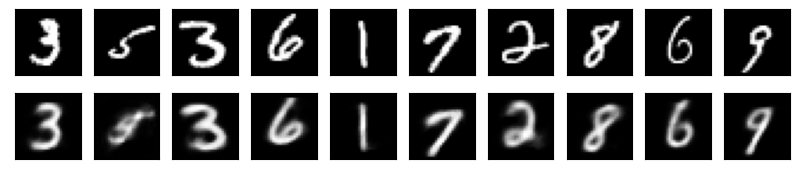

20 / 20
[Epoch 20]


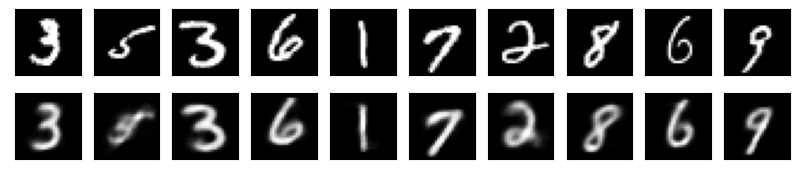

In [7]:
for epoch in range(1, EPOCH+1):
    print(epoch, "/" ,EPOCH)
    train(autoencoder, train_loader)
    
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [8]:
encoder = autoencoder.encoder
encoder.eval() # switch the encoder to evaluation mode

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=4, bias=True)
)

In [9]:
def classify_train(classifier, train_loader, loss_fn):
    classifier.train()
    size = len(train_loader.dataset)
    
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
        x  = (x-mean)/std
        
        result = classifier(x)
        
#         loss = classify_criterion(result, label)
        loss = loss_fn(result, label)
        
        if step == 1:
            loss_history.append(loss.data)
        
        classify_optimizer.zero_grad()
        loss.backward()
        classify_optimizer.step()

        if step % 100 == 0:
            loss, current = loss.item(), step * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def classify_test(classifier, test_loader, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for step, (x, label) in enumerate(test_loader):
            x = x.view(-1, 28*28).to(DEVICE)
            label = label.to(DEVICE)
            
            mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
            x  = (x-mean)/std
            
            result = classifier(x)
#             loss = classify_criterion(result, label)
            test_loss += loss_fn(result, label).item()
            correct += (result.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [11]:
classifier = Classifier(encoder).to(DEVICE)
classify_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
classify_criterion = nn.CrossEntropyLoss()

In [12]:
for epoch in range(1, EPOCH+1):
    print(epoch)
    classify_train(classifier, train_loader, classify_criterion)
    classify_test(classifier, test_loader, classify_criterion)

1
loss: 5.728314  [    0/60000]
loss: 0.416189  [ 6400/60000]
loss: 0.292349  [12800/60000]
loss: 0.272633  [19200/60000]
loss: 0.339282  [25600/60000]
loss: 0.136030  [32000/60000]
loss: 0.217153  [38400/60000]
loss: 0.250667  [44800/60000]
loss: 0.184473  [51200/60000]
loss: 0.235231  [57600/60000]
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.200513 

2
loss: 0.212241  [    0/60000]
loss: 0.090488  [ 6400/60000]
loss: 0.147023  [12800/60000]
loss: 0.221045  [19200/60000]
loss: 0.187488  [25600/60000]
loss: 0.251535  [32000/60000]
loss: 0.189134  [38400/60000]
loss: 0.129983  [44800/60000]
loss: 0.171764  [51200/60000]
loss: 0.100798  [57600/60000]
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.165531 

3
loss: 0.062220  [    0/60000]
loss: 0.052298  [ 6400/60000]
loss: 0.179215  [12800/60000]
loss: 0.022647  [19200/60000]
loss: 0.112670  [25600/60000]
loss: 0.136797  [32000/60000]
loss: 0.081790  [38400/60000]
loss: 0.141740  [44800/60000]
loss: 0.131685  [51200/60000]
loss: 0.070428  [576